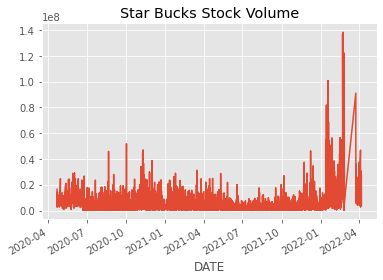

In [1]:
import numpy as np
import pandas as pd

df = pd.read_csv('SBER.csv', parse_dates=True, sep=';',index_col = 'DATE' )

import matplotlib.pyplot as plt
plt.style.use('ggplot')
df['VOL'].plot(label='CLOSE', title='Star Bucks Stock Volume')

X = df.iloc[:-1, 2:7]
y = df.iloc[1:,6:7]


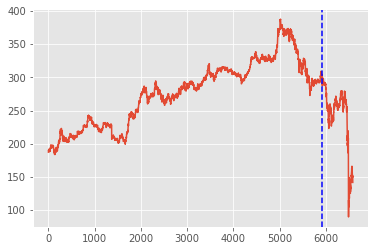

In [2]:
#df['CLOSE'].plot(label='CLOSE', title='CLOSE')
close = np.array(df.CLOSE)
plt.plot(close)
num = round(len(df)*0.9)
plt.axvline(x=num, c='b', linestyle='--')
#df['DATE']

In [3]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
mm = MinMaxScaler()
ss = StandardScaler()


X_ss = ss.fit_transform(X)
y_mm = mm.fit_transform(y) 

X_train = X_ss[:num, :]
X_test = X_ss[num:, :]

y_train = y_mm[:num, :]
y_test = y_mm[num:, :] 

print("Training Shape", X_train.shape, y_train.shape)
print("Testing Shape", X_test.shape, y_test.shape) 


Training Shape (5926, 5) (5926, 1)
Testing Shape (658, 5) (658, 1)


In [4]:
import torch #pytorch
import torch.nn as nn

X_train_tensors = (torch.Tensor(X_train))
X_test_tensors = (torch.Tensor(X_test))

y_train_tensors = (torch.Tensor(y_train))
y_test_tensors = (torch.Tensor(y_test)) 

In [5]:
X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))


X_test_tensors_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1])) 

print("Training Shape", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_final.shape, y_test_tensors.shape) 

Training Shape torch.Size([5926, 1, 5]) torch.Size([5926, 1])
Testing Shape torch.Size([658, 1, 5]) torch.Size([658, 1])


In [6]:
class LSTM1(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers,batch_first=True) #lstm , 
        self.fc_1 =  nn.Linear(hidden_size, 128) #fully connected 1
        self.fc = nn.Linear(128, num_classes) #fully connected last layer

        self.relu = nn.ReLU()
    
    def forward(self,x):
        h_0 = (torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c_0 = (torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) #first Dense
        out = self.relu(out) #relu
        out = self.fc(out) #Final Output
        return out


In [7]:

num_epochs = 1000 #1000 epochs
learning_rate = 0.001 #0.001 lr

input_size = 5 #number of features
hidden_size = 16 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers, X_train_tensors_final.shape[1]) #our lstm class 

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate)

In [8]:

for epoch in range(num_epochs):
  outputs = lstm1.forward(X_train_tensors_final) #forward pass
  optimizer.zero_grad() #caluclate the gradient, manually setting to 0
 
  # obtain the loss function
  loss = criterion(outputs, y_train_tensors)
 
  loss.backward() #calculates the loss of the loss function
 
  optimizer.step() #improve from loss, i.e backprop
  if epoch % 100 == 0:
    print("Epoch: %d, loss: %1.5f" % (epoch, loss.item())) 

Epoch: 0, loss: 0.43138
Epoch: 100, loss: 0.00112
Epoch: 200, loss: 0.00008
Epoch: 300, loss: 0.00004
Epoch: 400, loss: 0.00003
Epoch: 500, loss: 0.00003
Epoch: 600, loss: 0.00003
Epoch: 700, loss: 0.00002
Epoch: 800, loss: 0.00002
Epoch: 900, loss: 0.00002


In [9]:

df_X_ss = ss.transform(df.iloc[:, 2:7]) #old transformers
df_y_mm = mm.transform(df.iloc[:, 6:7]) #old transformers

df_X_ss = (torch.Tensor(df_X_ss)) #converting to Tensors
df_y_mm = (torch.Tensor(df_y_mm))
#reshaping the dataset
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 1, df_X_ss.shape[1])) 

train_predict = lstm1(df_X_ss)#forward pass
data_predict = train_predict.data.numpy() #numpy conversion
dataY_plot = df_y_mm.data.numpy()

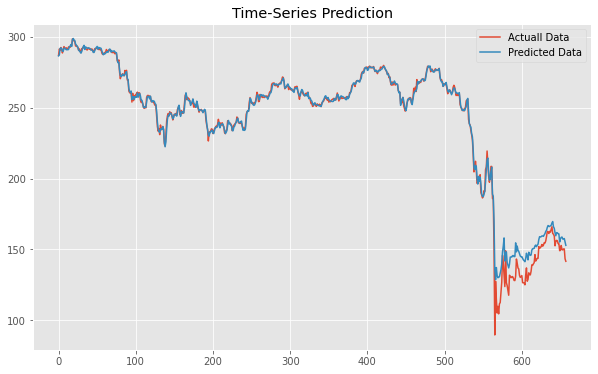

In [10]:
data_predict = mm.inverse_transform(data_predict) #reverse transformation
dataY_plot = mm.inverse_transform(dataY_plot)
data_predict = data_predict[-y_test.size:]
dataY_plot = dataY_plot[-y_test.size:]

plt.figure(figsize=(10,6)) #plotting
#plt.axvline(x=200, c='r', linestyle='--') #size of the training set

plt.plot(dataY_plot, label='Actuall Data') #actual plot
plt.plot(data_predict, label='Predicted Data') #predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.show() 

In [11]:
data_predict = data_predict.squeeze()
y_test = y_test.squeeze()
d_predict = np.diff(data_predict[:])
d_y = np.diff(y_test[:])

In [12]:
d = d_predict>0 
d_predict[d] = 1
d = d_predict<=0 
d_predict[d] = -1

d = d_y>0
d_y[d] = 1
d = d_y<=0
d_y[d] = -1


In [13]:
p = d_y == d_predict
s = np.sum(p)
print(s/np.size(d_y))

0.700152207001522


In [14]:

profit = d_predict*np.diff(y_test)
print(profit)
profit = profit.cumsum()

[ 1.47310493e-02 -2.98647696e-03  6.61051643e-03  4.63071709e-03
  8.22120063e-03 -6.97963156e-03  8.01986511e-03 -3.95959867e-03
  6.71118419e-04 -1.87913157e-03 -2.75158552e-03 -7.04674340e-04
  4.22804604e-03  0.00000000e+00 -8.72453944e-04  3.82537499e-03
 -3.02003288e-04  1.58383947e-02 -2.78514144e-03  2.38247039e-03
  1.17445723e-03  1.07714506e-02 -1.81201973e-03  3.45625986e-03
  1.20801315e-03  7.34874669e-03 -3.32203617e-03  6.20784537e-03
  2.31535855e-03  9.42921378e-03 -2.01335526e-04  3.92604275e-03
 -1.44290460e-03  2.51669407e-03 -2.34891447e-04  1.17445723e-03
  1.91268749e-03 -4.93272038e-03 -1.64424013e-03  1.54357236e-03
 -5.03338814e-04  2.01335526e-03 -2.58380591e-03  2.11402302e-03
  4.99983222e-03 -1.51001644e-03  6.17428945e-03 -4.69782893e-04
  9.06009865e-04  4.02671051e-04  2.68447368e-04 -2.68447368e-03
 -2.68447368e-04 -5.70450656e-04 -7.04674340e-04  8.32186839e-03
  3.48981578e-03 -2.34891447e-03 -1.07378947e-03 -3.12070065e-03
  1.71135197e-03  5.33539

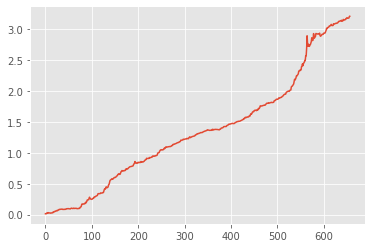

In [15]:
plt.plot(profit)